# Environment setup
Follow the tutorial about how to utilize Google Colab but **don't install PyTorch** as mentioned in the blog post.

Turkish:
https://medium.com/deep-learning-turkiye/google-colab-ile-%C3%BCcretsiz-gpu-kullan%C4%B1m%C4%B1-30fdb7dd822e

English:
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d




# Now, you will work on the problem of Food Classification using a subset of Food-101 data, where you have 50 classes 

After having mounted the Jupyter Notebook to Google Drive, navigate the following address:

https://drive.google.com/open?id=13zG2cXkDZiSGZTALgZD09OP7HSF1twWV

Add this folder entirely to your Google Drive. If you have done it correctly, then you should be able to see blg561 in your drive.

Let's try it with an simple example



### Don't forget to choose the right runtime from the menu above. (GPU should be selected)

In [0]:
!nvidia-smi
# This command should return some information about the GPU status if the runtime is right. 
# In addition to that, if you encounter memory issues, you can diagnose your model by this command.

Fri Nov 23 19:02:02 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
# This is for navigating to the work folder. 
%cd /content/drive/My\ Drive/BLG561E

/content/drive/My Drive/BLG561E


In [0]:
!pip3 install -r blg561/requirements.txt
# This code should install the required software if you did the integration correctly.

    100% |████████████████████████████████| 519.5MB 31kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59a44000 @  0x7fac7f14d2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 20.6MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.


You are free to utilize Pytorch methods in this part of the Homework. 
You will be using pretained models VGG16, ResNet, Inception and your own model.

Below, you will find required modules loaded. 

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.functional import normalize, resize, to_tensor
import torchvision.models as models
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

## DataLoader and Dataset
Here, we provide you an almost fully functional Dataset but to ensure that you understood how it works, we request you to do a little adjustment. Try to understand how this loader code works and add Train/Test/Validation split to dataset.

In [0]:
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
    for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

### The code below is to make you be able to load by using Pillow.
class Food101Loader(Dataset):
    def __init__(self, path, mode='train'):
        self.images_path = os.path.join(path, './')
        self.image_names = {}
        for i,d in enumerate(os.listdir(self.images_path)):
            try:
                d = os.path.join(self.images_path, d)
                single_class_path = {os.path.join(d,im):i for im in os.listdir(d)}
                self.image_names= {**self.image_names, **single_class_path}
            except:
                print('err')
        
        self.image_names = [el for el in self.image_names.items()]
        
        def data_splitter(image_names, mode):
          image_names = []
          for i in range(0, 5000, 1000):
            if mode == "train":
              image_names.extend(self.image_names[i:i+600])
            if mode == "test":
              image_names.extend(self.image_names[i+600:i+800])
            if mode == "val":
              image_names.extend(self.image_names[i+800:i+1000])
  
          return image_names
        
        if mode == 'train':
            self.image_names = data_splitter(self.image_names, mode)
        if mode == 'test':
            self.image_names = data_splitter(self.image_names, mode)
        if mode == 'val':
            self.image_names = data_splitter(self.image_names, mode)
            
    # This method normalizes each image individually. You may want to normalize it by using ImageNet statistics
    # If you would like to fine tune so feel free to do changes
    def preprocess(self, x):
        x = resize(x, (224, 224))
        x = np.asarray(x)
        x = x.transpose((2,0,1))
        x = torch.from_numpy(x).type(torch.float)
        normalize(x,  mean=[el.mean() for el in x] ,std=[el.std() for el in x])
        return x
    
    # This method basically loads image from the file system
    def load(self, path):
        img = Image.open(path)
        img.load()
        return img

    # This method should be overrided in order to access the inside of dataset
    def __getitem__(self, ix):
        # Get its relative path and label
        data_path, label = self.image_names[ix]
        
        # Load image
        data = self.load(data_path)
        data_normalized = self.preprocess(data)
        data_normalized = data_normalized
        
        # Then return the data and its label.
        return data_normalized, label
        
        
    # This method should be overrided in order to make it work along with DataLoader class
    def __len__(self):
        return len(self.image_names)

# Load separately VGG16, ResNet, Inception models

You can find tutorials on how to load those models at pytorch.org . Don't forget to use pretrained=True if you wish to do finetuning.

In [0]:
# Load models here
vgg16 = models.vgg16(pretrained=True)
resnet18 = models.resnet18(pretrained=True)
inception = models.inception_v3(pretrained=True)


# Additionally, build your own model which is different from the other models, train on the Food dataset
**Report your loss curves at the end of the notebook**

In [0]:
class YourModel(nn.Module):
    def __init__(self, num_classes=5):
        super(YourModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(100352, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out
      
model = YourModel()

In [0]:
# v1
class YourModelv1(nn.Module):
    def __init__(self):
        super(YourModelv1, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(56 * 56 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)
    def forward(self, x):
      out = self.layer1(x)
      out = self.layer2(out)
      out = out.reshape(out.size(0), -1)
      out = self.drop_out(out)
      out = self.fc1(out)
      out = self.fc2(out)
      return out
    
model = YourModelv1()

In [0]:
#v2
class YourModelv2(nn.Module):
  """This is basically LeNet"""
    def __init__(self):
        super(YourModelv2, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(44944, 32)
        self.fc2   = nn.Linear(32, 32)
        self.fc3   = nn.Linear(32, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out
      
model = YourModelv2()

In [0]:
class YourModelv3(nn.Module):
    def __init__(self):
        super(YourModelv3, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(6272, 1000)
        self.fc2 = nn.Linear(1000, 10)
    def forward(self, x):
      out = self.layer1(x)
      out = self.layer2(out)
      out = self.layer3(out)
      out = self.layer4(out)
      out = out.reshape(out.size(0), -1)
      out = self.drop_out(out)
      out = self.fc1(out)
      out = self.fc2(out)
      return out
    
model = YourModelv3()

In [0]:
class YourModelv4(nn.Module):
    def __init__(self):
        super(YourModelv4, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(6272, 1000)
        self.fc2 = nn.Linear(1000, 10)
    def forward(self, x):
      out = self.layer1(x)
      out = self.layer2(out)
      out = self.layer3(out)
      out = self.layer4(out)
      out = out.reshape(out.size(0), -1)
      out = self.drop_out(out)
      out = self.fc1(out)
      out = self.fc2(out)
      return out
    
model = YourModelv4()

In [0]:
batch_size = 32
dataset_train = Food101Loader(path='/content/drive/My Drive/BLG561E/blg561/data', mode='train')
dataset_test = Food101Loader(path='/content/drive/My Drive/BLG561E/blg561/data', mode='test')
dataset_val = Food101Loader(path='/content/drive/My Drive/BLG561E/blg561/data', mode='val')

train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=dataset_test, batch_size=32, num_workers=4, shuffle=False)
val_loader = DataLoader(dataset=dataset_val, batch_size=32, num_workers=4, shuffle=False)

In [0]:
# torch.save(model.state_dict(), '/content/drive/My Drive/BLG561E/vgg16.ckpt')
model = YourModel()
model.load_state_dict(torch.load('/content/drive/My Drive/BLG561E/modelv1.ckpt'))
model.cuda()

YourModel(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5)
  (fc1): Linear(in_features=200704, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)

In [6]:
###  Here are some training parameters
batch_size = 32
learning_rate = 1e-3
regularization_rate = 0
n_epochs = 30
use_gpu = False
test_every = 3
print_every  = 1
steps = 0
run_loss = 0
###

model = model
# You may want to tweak them too.
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.99, weight_decay = 1e-5)
criteria = nn.CrossEntropyLoss()
# It modifies the behaviour of modules like BatchNorm and Dropout for training purposes
model.cuda()
criteria.cuda()

model.train()

# Some example diagnostics.

# Loss for every iteration
losses_iter_train = []

# Loss for epoch (averaging the iteration-wise loss)
losses_epoch_train = []
accuracy_iter_train = []

# Validation part
losses_iter_val = []
losses_epoch_val = []
accuracy_iter_val = []

# Write the training loop
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#train-the-network

for epoch in range(n_epochs):
    print('Epoch Number: ', epoch)
    steps += 1

    for ix, data in enumerate(train_loader):
        
        # Get the inputs
        img, label = data    
        img = img.cuda()
        label = label.cuda()
        
        # Forward Pass
        outputs = model.forward(img)
        loss = criteria(outputs, label)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Calculate gradients for backward pass
        loss.backward()
        
        # Optimize
        optimizer.step()

        # Train Loss
        losses_iter_train.append(loss.item())
        losses_epoch_train = np.mean(losses_iter_train)
        
        # Train Accuracy
        ps = torch.exp(outputs).data
        equality = (label.data == ps.max(1)[1])
        accuracy_iter_train.append(equality.type_as(torch.FloatTensor()).mean())
        if ix % 10 == 0:
          print('Iter Loss:', losses_iter_train[ix], ' of ', ix, '/',len(train_loader), 'data')          
        if ix % 90 == 0:
          print('Mean Loss:', losses_epoch_train, ' of ', ix, '/',len(train_loader), 'data')


    if steps % test_every == 0:

      model.eval()

      for img, label in iter(val_loader):
        img, label = Variable(img), Variable(label)
        img = img.cuda()
        label = label.cuda()

        with torch.no_grad():
          outputs = model.forward(img)
          # Validation Loss
          losses_iter_val.append(criteria(outputs, label).data.item())
          losses_epoch_val = np.mean(losses_iter_val)
          # Validation Accuracy
          ps = torch.exp(outputs).data
          equality = (label.data == ps.max(1)[1])
          accuracy_iter_val.append(equality.type_as(torch.FloatTensor()).mean())
        #print("Epoch: {}, Validation Loss: {}, Validation Accuracy: {}".format(epoch, loss, val_acc))
      '''print("Epoch: {}/{}.. ".format(epoch+1, n_epochs),
       "Training Loss: {:.3f}.. ".format(losses_epoch_train),
        "Val Loss: {:.3f}.. ".format(losses_epoch_val),
        "Val Accuracy: {:.3f}".format(accuracy_iter_val[]))'''

      model.train()
            
#Save_Path = '../Colab Notebooks'
#Save_Name = 'resnet18.npz'
#np.savez_compressed(os.path.join(Save_Path, Save_Name), val_losses = losses_epoch_val, val_accs = accuracy_iter_val, train_losses = accuracy_iter_train, train_accs = accuracy_iter_train)

torch.save(model.state_dict(), '/content/drive/My Drive/BLG561E/modelv4.ckpt')


Epoch Number:  0
Iter Loss: 2.3088340759277344  of  0 / 94 data
Mean Loss: 2.3088340759277344  of  0 / 94 data
Iter Loss: 2.27192759513855  of  10 / 94 data
Iter Loss: 1.993098258972168  of  20 / 94 data
Iter Loss: 2.2352051734924316  of  30 / 94 data
Iter Loss: 1.8209706544876099  of  40 / 94 data
Iter Loss: 1.9229083061218262  of  50 / 94 data
Iter Loss: 1.8635780811309814  of  60 / 94 data
Iter Loss: 1.8241018056869507  of  70 / 94 data
Iter Loss: 1.7456718683242798  of  80 / 94 data
Iter Loss: 1.6708096265792847  of  90 / 94 data
Mean Loss: 1.941240171809773  of  90 / 94 data
Epoch Number:  1
Iter Loss: 2.3088340759277344  of  0 / 94 data
Mean Loss: 1.9277623578121788  of  0 / 94 data
Iter Loss: 2.27192759513855  of  10 / 94 data
Iter Loss: 1.993098258972168  of  20 / 94 data
Iter Loss: 2.2352051734924316  of  30 / 94 data
Iter Loss: 1.8209706544876099  of  40 / 94 data
Iter Loss: 1.9229083061218262  of  50 / 94 data
Iter Loss: 1.8635780811309814  of  60 / 94 data
Iter Loss: 1.8241

In [0]:
#94#
np.savez_compressed("/content/drive/My Drive/BLG561E/modelv4.npz", val_losses = losses_epoch_val, val_accs = accuracy_iter_val, train_losses = losses_iter_train, train_accs = accuracy_iter_train)


** Finetune/Train the loaded/designed model here:**

Don't forget to include appropriate regularizations.
Choose appropriate set of hyperparameters such as Learning Rate etc.

You may insert new cells.

### Measure the performance against validation set
Complete the code

In [8]:
model.eval()

with torch.no_grad():
   correct = 0
   total = 0
   for img, label in iter(test_loader):
       img, label = Variable(img), Variable(label)
       img = img.cuda()
       label = label.cuda()
       outputs = model(img)
       _, predicted = torch.max(outputs.data, 1)
       total += label.size(0)
       correct += (predicted == label).sum().item()

   print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 54.8 %


** Run diagnostics for each model (VGG16, Resnet etc). Avoid overfitting and underfitting as much as possible.
We expect you to get at least 75% Test Accuracy**

In [0]:
# Load VGG16 from Drive
vgg_16 = np.load("/content/drive/My Drive/BLG561E/vgg16_1.npz")
train_losses_vgg16 = vgg_16["train_losses"]
losses_epoch_vgg16 = vgg_16["val_losses"]

train_losses_mean_vgg16 = []
for i in range(int(len(train_losses_vgg16)/94)):
  train_losses_mean_vgg16.append(np.mean(train_losses_vgg16[i*94:(i+1)*94]))

** Plot the training, validation, and test losses versus number of iterations or epochs for VGG16 on the same plot**

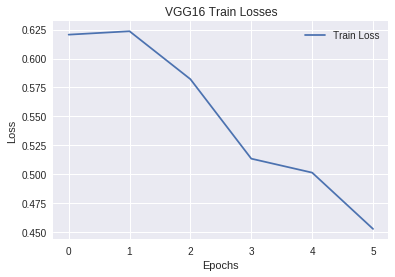

VGG16 Validation Losses [0.6205814981714208, 0.623522696976966, 0.5821454813505741, 0.5135625749826431, 0.5015165168554225, 0.45294412875429113]


In [28]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(range(len(train_losses_mean_vgg16)), train_losses_mean_vgg16, label='Train Loss')
ax.legend()

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG16 Train Losses')
plt.grid(True)
plt.show()


In [29]:
print("Validation loss for VGG16 is: ", losses_epoch_vgg16)

Validation loss for VGG16 is:  0.7964918832294643


** Plot the training, validation, and test losses versus number of iterations or epochs for ResNet on the same plot**

In [30]:
resnet_18 = np.load("/content/drive/My Drive/BLG561E/resnet18_1.npz")
train_losses_res18 = resnet_18["train_losses"]
losses_epoch_res18 = resnet_18["val_losses"]

train_losses_mean_res18 = []
for i in range(int(len(train_losses_res18)/94)):
  train_losses_mean_res18.append(np.mean(train_losses_vgg16[i*94:(i+1)*94]))

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


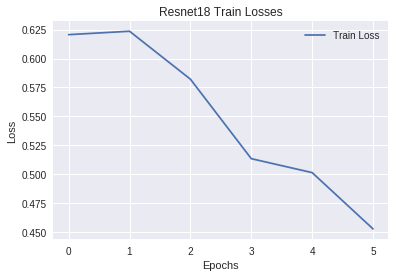

In [33]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(range(len(train_losses_mean_res18)), train_losses_mean_res18, label='Train Loss')
ax.legend()

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Resnet18 Train Losses')
plt.grid(True)
plt.show()


In [32]:
print("Validation loss for Resnest18 is: ", losses_epoch_res18)

Validation loss for Resnest18 is:  0.7886888228356839


** Plot the training, validation, and test losses versus number of iterations or epochs for Inception on the same plot**

** Rather than using pretrained weights, first, initialize the weights by using small gaussian with zero mean and unit variance. Secondly, use the Xavier (Glorot) strategy to initialize the weights. Finally, discuss about the differences by comparing number of the epochs required to reach same testing accuracy, loss curves etc.**

For more information about Xavier initialization, check out the following link:

X. Glorot, Y. Bengio, 2010. Understanding the difficulty of training deep feedforward neural networks:  http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf

** Plot the training, validation, and test losses versus number of iterations or epochs for your model on the same plot**

In [35]:
mymodel = np.load("/content/drive/My Drive/BLG561E/modelv4.npz")
train_losses_mymodel = mymodel["train_losses"]
losses_epoch_mymodel = mymodel["val_losses"]

train_losses_mean_mymodel = []
for i in range(int(len(train_losses_res18)/94)):
  train_losses_mean_mymodel.append(np.mean(train_losses_mymodel[i*94:(i+1)*94]))

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


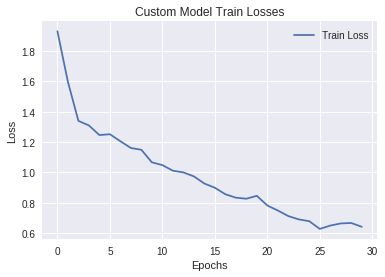

In [36]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(range(len(train_losses_mean_mymodel)), train_losses_mean_mymodel, label='Train Loss')
ax.legend()

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Custom Model Train Losses')
plt.grid(True)
plt.show()


In [37]:
print("Validation loss for custom model is: ", losses_epoch_mymodel)

Validation loss for custom model is:  1.2529722462873907


#### After you have completed the training, save your best model using the following command


In [0]:
student_id = 511161185
torch.save(model.state_dict(), '/content/drive/My Drive/BLG561E/{}.pth'.format(student_id))